# Part 07: BD-e2 Model Deployment

The GEDI EE Hyperspace was designed to generate GEDI AGBD Predictions by looping through all images (i.e. predictors) within an assigned directory and output those results accordingly. Users should already have done an indepth analysis on GEDI values and their predictors and have a saved model to input into this script. The following information is required prior to begining:

1. Saved Model (i.e. trained model)
2. Saved y_test and y_pred (from y_train) data. This will be used for Empirical Distribution Matching (EDM)
3. Imagery Predictors

# Load in appropriate Libraries

Load in all the python library packages you will need

In [ ]:
import rasterio
from rasterio.plot import reshape_as_image

# import rasterstats
import scipy.ndimage
from sklearn import  metrics 
import joblib

import time

# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


%matplotlib inline

# To install sklearn type "pip install numpy scipy scikit-learn" to the anaconda terminal

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

# Datetime lib
from pandas import to_datetime
import warnings
import datetime
warnings.filterwarnings('ignore')

from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import linregress
# from scipy.stats import CensoredData

import fiona

import time

# Load in Ancilary Machine Learning Data

In [ ]:
mX = 'M0' 
model = 'LightGBM_DART'
studyArea = 'EE_Kenobi'
year01 = 1985
year02 = 2023

transform = 'log' #log
date = '20240204'

noTransform = False
SQRT = False
LOG = True

EDM = True

mlAlgoPath = f'D:/Argus/BDe2/models/final/{model}'

algo = os.path.join(mlAlgoPath,"finalM0_GEDI_EE_Kenobi_LightGBM_DART_log_20250329.sav")

# if ROE_Duan:
#     algoSLR = os.path.join(mlAlgoPath,f"{mX}_residualSLR_GEDI_EE_Kenobi_impFeatures_{model}_{transform}_20240124.sav")
#     calibrationROE = joblib.load(algoSLR)


y_predArray = os.path.join(mlAlgoPath,f"{mX}_y_pred_{transform}_{model}.npy")
y_predTrainArray = os.path.join(mlAlgoPath,f"{mX}_y_pred_train_{transform}_{model}.npy")
y_trainCSV = os.path.join(mlAlgoPath,f"{mX}_y_train_{transform}_{model}.csv")
y_testCSV = os.path.join(mlAlgoPath,f"{mX}_y_test_{transform}_{model}.csv")

X_trainCSV = os.path.join(mlAlgoPath,f"{mX}_X_train_{model}.csv")
X_testCSV = os.path.join(mlAlgoPath,f"{mX}_X_test_{model}.csv")

y_fullCSV = os.path.join(mlAlgoPath,f"{mX}_ydf_{transform}_{model}.csv")
# y_predFullArray = os.path.join(mlAlgoPath,f"{mX}_y_pred_full_{transform}_{model}.npy")

lgbm_model = joblib.load(algo)
# calibrationROE = joblib.load(algoSLR)

y_pred = np.load(y_predArray)
y_pred_train = np.load(y_predTrainArray)
# y_pred_full = np.load(y_predFullArray)

y_train = pd.read_csv(y_trainCSV, index_col=0).squeeze()
y_test = pd.read_csv(y_testCSV, index_col=0).squeeze()
# y_full = pd.read_csv(y_fullCSV, index_col=0).squeeze()

## Load X Train
X_train = pd.read_csv(X_trainCSV, index_col=0)
X_test = pd.read_csv(X_testCSV, index_col=0)

# Load ROE Duan Roe Smearing Factor
duanSmearingTXT = os.path.join(mlAlgoPath,f"{model}_DuanROE_factor_20250330.txt")
with open(duanSmearingTXT, "r") as file:
    duanSmearing = float(file.readline().strip())

# Empiracal Distribution Matching and Visualization

https://stackoverflow.com/questions/44132543/python-inverse-empirical-cumulative-distribution-function-ecdf

In [7]:
y_train_EDM = ECDF(y_train)
y_pred_EDM_lgbm = ECDF(y_pred) #y_pred_xgb_final, y_pred

In [ ]:
yC = y_train_EDM.y[y_train_EDM.y<=y_train_EDM(np.max(y_pred))]
yC = yC[yC>y_train_EDM(np.min(y_pred))]

yxc = y_train_EDM.x[y_train_EDM.x<=np.max(y_pred)]
yxc = yxc[yxc>=np.min(y_pred)]


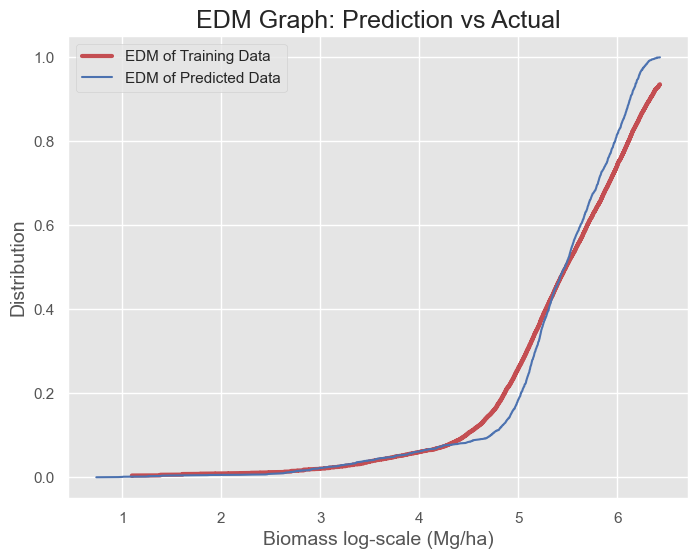

In [10]:
with plt.style.context("ggplot"):
    plt.rcParams["axes.grid"] = True

    plt.plot(yxc, yC, 'r', label = "EDM of Training Data" , linewidth = 3)
    plt.plot(y_pred_EDM_lgbm.x, y_pred_EDM_lgbm.y, 'b', label = "EDM of Predicted Data")
    # plt.plot(y_train_EDM2.x, y_train_EDM2.y, 'g', label = "TRain 2" )


    plt.title("EDM Graph: Prediction vs Actual", fontsize=18)
    plt.xlabel("Biomass log-scale (Mg/ha)", fontsize=14)
    plt.ylabel("Distribution", fontsize=14)


    plt.legend()
    plt.show()

In [ ]:
slope_changes = sorted(set(yxc))

sample_edf_values_at_slope_changes = [ y_train_EDM(item) for item in slope_changes]
inverted_edf = interp1d(sample_edf_values_at_slope_changes,slope_changes, fill_value="extrapolate", kind="linear")#fill_value="extrapolate") #fill_value="extrapolate"

Y_NEW_Pred_EDM_lgbm = inverted_edf(y_pred_EDM_lgbm(y_pred)) #y_pred_xgb_final / y_pred

y_pred_corrected_lgbm = ECDF(Y_NEW_Pred_EDM_lgbm)

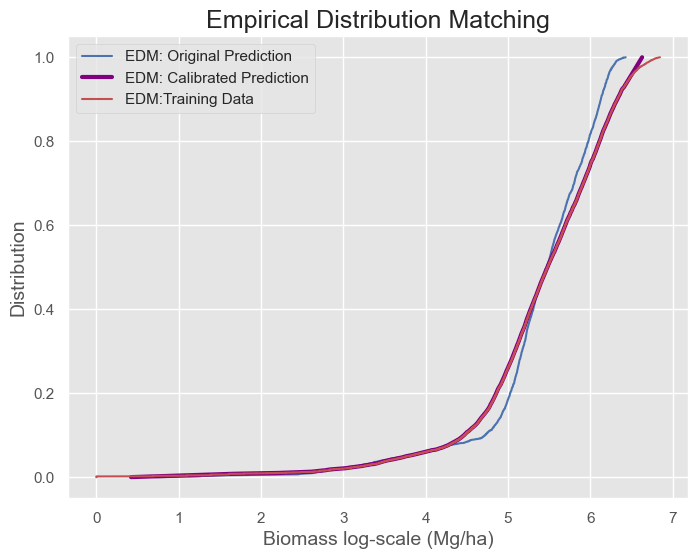

In [ ]:
# plt.plot(y_train_EDM.x, y_train_EDM.y, 'r')
with plt.style.context("ggplot"):
    plt.rcParams["axes.grid"] = True

    plt.plot(y_pred_EDM_lgbm.x, y_pred_EDM_lgbm.y, 'b', label = "EDM: Original Prediction" )
    plt.plot(y_pred_corrected_lgbm.x, y_pred_corrected_lgbm.y, 'purple', linewidth=3, label = "EDM: Calibrated Prediction" )
    plt.plot(y_train_EDM.x, y_train_EDM.y, 'r', label = "EDM:Training Data" )
    plt.title("Empirical Distribution Matching", fontsize=18)
    plt.xlabel("Biomass log-scale (Mg/ha)", fontsize=14)
    plt.ylabel("Distribution", fontsize=14)

    # plt.style.context("seaborn-white")
    # plt.rcParams["axes.grid"] = True
    plt.legend()
    plt.show()


In [16]:
r_square_lgbm_final = metrics.r2_score(y_test,Y_NEW_Pred_EDM_lgbm)
print('R-Square Error associated with LightGBM Regression is:', r_square_lgbm_final)
rmse_lgbm_final = metrics.root_mean_squared_error(y_test, Y_NEW_Pred_EDM_lgbm)
print('RMSE associated with LightGBM Regression is:', rmse_lgbm_final)
rms_lgbm_final = metrics.mean_squared_error(y_test, Y_NEW_Pred_EDM_lgbm)
print('MSE associated with LightGBM Regression is:', rms_lgbm_final)
mae_lgbm_final = metrics.mean_absolute_error(y_test, Y_NEW_Pred_EDM_lgbm)
print('MAE associated with LightGBM Regression is:', mae_lgbm_final)

R-Square Error associated with LightGBM Regression is: 0.7430019951731264
RMSE associated with LightGBM Regression is: 0.447049680033176
MSE associated with LightGBM Regression is: 0.19985341641776508
MAE associated with LightGBM Regression is: 0.3503586537445175


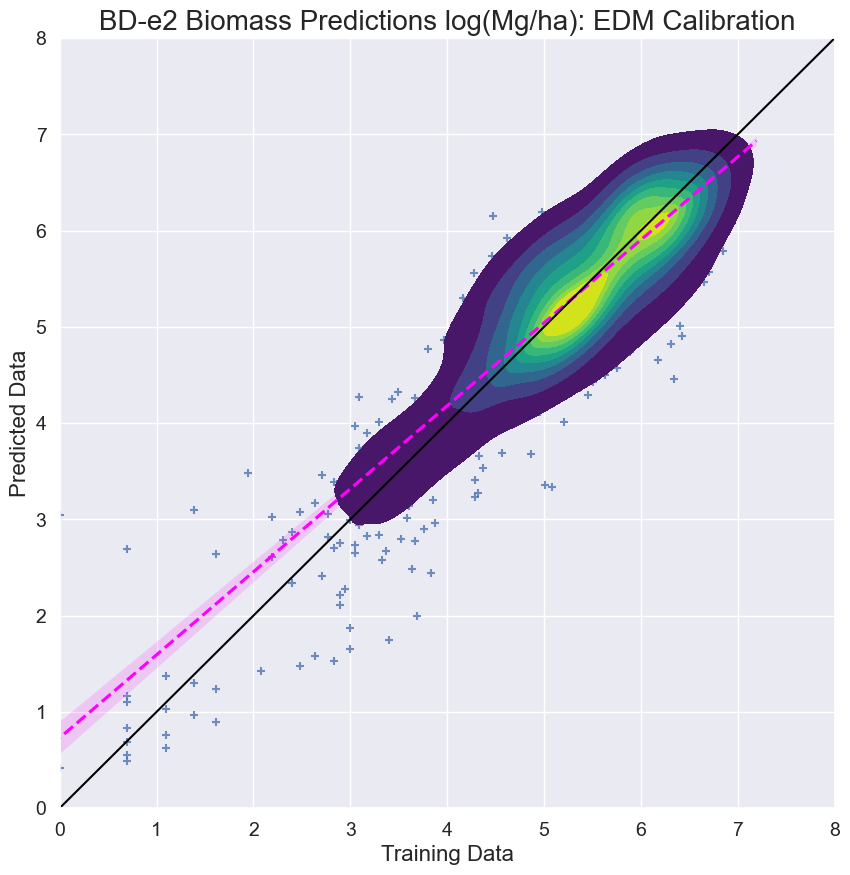

f(x): y=0.8624x+0.7302


In [20]:
plt.figure(figsize=(10,10))

# sns.relplot(x=y_test,y=y_pred)
# sns.relplot(x=y_test,y=y_pred, marker="+")
q = sns.regplot(x=y_test,y=Y_NEW_Pred_EDM_lgbm,marker="+",truncate=False,line_kws={"color": "fuchsia",
                                                                               "linestyle":"--"})

sns.kdeplot(x=y_test,y=Y_NEW_Pred_EDM_lgbm,fill=True, cmap="viridis") #mako

# color='fuchsia',linestyle='--',lw = 2.5

plt.plot([0, 8], [0, 8], color="black")
# plt.title("LightGBM Biomass Predictions log(Mg/ha): Original", fontsize=18)
# plt.xlabel("Biomass Training Data", fontsize=14)
# plt.ylabel("Biomass Predicted Data", fontsize=14)

# plt.legend(fontsize=14)
plt.title("BD-e2 Biomass Predictions log(Mg/ha): EDM Calibration", fontsize=20)
plt.xlabel("Training Data", fontsize=16)
plt.ylabel("Predicted Data", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0,8)
plt.ylim(0,8)
plt.show()

#Get Linear Equation:
slope, intercept, r, p, sterr = scipy.stats.linregress(x=q.get_lines()[0].get_xdata(),
                                                      y = q.get_lines()[0].get_ydata())

print(f"f(x): y={round(slope,4)}x+{round(intercept,4)}")

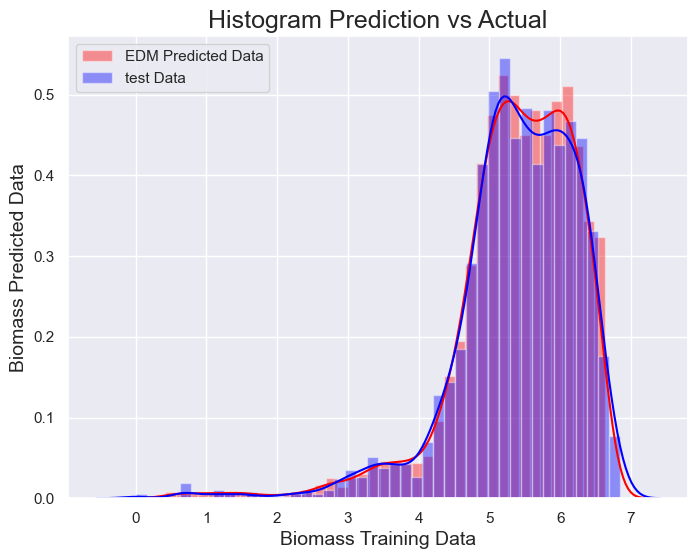

In [21]:
plt.figure() #plt.figure(figsize=(14,8))

sns.distplot(Y_NEW_Pred_EDM_lgbm,color='red', label = "EDM Predicted Data")
sns.distplot(y_test,color='blue', label = "test Data")

plt.title("Histogram Prediction vs Actual", fontsize=18)
plt.xlabel("Biomass Training Data", fontsize=14)
plt.ylabel("Biomass Predicted Data", fontsize=14)

plt.legend()

plt.show()

# Loop through Image using assigned Model
Note: This section is still under development for optimization

In [ ]:
with fiona.open(gnnMaskShp, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

print("\nInitiating GEDI EE Hyperspace")

for yr in range(year01,year02+1):
    
    print(f"\n*****Executing Year {yr}*****\n")
    startTime = time.process_time()
    
    newImage = os.path.join(destImgDir_Original, f"noMask_GEDI_{studyArea}_AGBD_Original_{model}_yr{yr}.tif")
    newImage2 = os.path.join(destImgDir_Original, f"Master_GEDI_{studyArea}_AGBD_Original_{model}_yr{yr}.tif")
    newImage3 = os.path.join(destImgDir_Cal, f"noMask_GEDI_{studyArea}_AGBD_Calibrated_{model}_yr{yr}.tif")
    newImage4 = os.path.join(destImgDir_Cal, f"Master_GEDI_{studyArea}_AGBD_Calibrated_{model}_yr{yr}.tif") #noMask_GEDI_EE_Kenobi_AGBD_Calibrated_LightGBM_yr2007


#     newImage5 = os.path.join(destImgDir_Cal2, f"noMask_C2_GEDI_{studyArea}_AGBD_Calibrated_{model}_yr{yr}.tif")
#     newImage6 = os.path.join(destImgDir_Cal2, f"Master_C2_GEDI_{studyArea}_AGBD_Calibrated_{model}_yr{yr}.tif")
    
    
  
    print(f"Part 01: Openning Raster")
    
#     out_fp = os.path.join(scrImgDir, f"Master_GEDI_EE_Kenobi_imgPredictors_TOA_Medoid_152_274_{yr}_{yr}_GOLD_20240120_v2.tif")
    out_fp = os.path.join(scrImgDir, f"GEDI_Kenobi_EE_LT_TOA_Summer_Medoid_152_274_{yr}_{yr}_impFeatures_20240207_seg6_FINAL.tif")
    #GEDI_Kenobi_EE_LT_TOA_Summer_Medoid_152_274_1985_1985_impFeatures_20240204_seg6_FINAL
    # Read in Raster Files
    with rasterio.open(out_fp,"r+") as src:
        src.nodata = -32768 # Change this is going to use Int16()!!!!!!!!!!!!!
        img = src.read(masked=False) ##Important!!!!


    reshaped_img = reshape_as_image(img)

    # Update Image to 2D Array
    reshaped_img2 = reshaped_img.reshape(-1, 31) #32

    # This is for RF
    # now predict but first reshape the image to that one long array
    print(f"Part 02: Applying {model}")
    lgbm_prediction = lgbm_model.predict(reshaped_img2) # Hmmmmmmmmmm....... why -1?

    # Reshape our classification map back into a 2D matrix so we can visualize it
#     lgbm_prediction = lgbm_prediction.reshape(reshaped_img[:, :, 0].shape)
    
    if EDM:
        # Reshape our classification map back into a 2D matrix so we can visualize it
        lgbm_prediction = lgbm_prediction.reshape(reshaped_img[:, :, 0].shape)
    
        print(f"Part 03: Calibrating {model} AGBD Prediction with EDM")
        # Apply EDM Function
        lgbm_prediction_calibrated = inverted_edf(y_pred_EDM_lgbm(lgbm_prediction))
        low_values_flags = lgbm_prediction_calibrated < 0  # Where values are low
        lgbm_prediction_calibrated[low_values_flags] = 0  # All low values set to 0
        
        if LOG:
            print(f"Part 03a: Back Transform Log Values")
            lgbm_prediction_logBack = ((np.exp(lgbm_prediction))*duanSmearing)/2.47105
            lgbm_prediction_calibrated_logBack = np.exp(lgbm_prediction_calibrated)/2.47105
            
        elif SQRT:
            print(f"Part 03a: Back Transform Square Root Values")
            lgbm_prediction_logBack = ((np.square(lgbm_prediction)))/2.47105
            lgbm_prediction_calibrated_logBack = np.square(lgbm_prediction_calibrated)/2.47105
            
    
    print(f"Part 04: Writing Raster to Drive")
    # start generating variables used for writing the geotiff image
    ds = rasterio.open(out_fp,"r+") # Original Image 30m Year Time frame (e.g. 2021 only)
    transform = ds.transform # transform parameters read from the original image
    crs = ds.crs # CRS parameters read from the original image
    

    # write the file in one go using all options
    with rasterio.open(
        newImage,
        'w',
        driver='GTiff',
        height=lgbm_prediction_logBack.shape[0],
        width=lgbm_prediction_logBack.shape[1],
        count=1,
        dtype = 'float32',
        crs = crs,
        transform=transform
    ) as dst:
        dst.write(lgbm_prediction_logBack, 1)
        
    dst = None


    with rasterio.open(newImage) as src:
        out_image, transformed = rasterio.mask.mask(src, shapes, crop=True, filled=True, nodata = -32768)
        out_profile = src.profile.copy()

    out_profile.update({'width': out_image.shape[2],'height': out_image.shape[1], 'transform': transformed, 'nodata': -32768})
    
    with rasterio.open(newImage2, 'w', **out_profile) as dst:
        dst.write(out_image)
        
    dst = None
    out_image = None
    out_profile = None
    src = None
        

    # start generating variables used for writing the geotiff image
    ds = rasterio.open(out_fp,"r+") # Original Image 30m Year Time frame (e.g. 2021 only)
    transform = ds.transform # transform parameters read from the original image
    crs = ds.crs # CRS parameters read from the original image

    with rasterio.open(
        newImage3,
        'w',
        driver='GTiff',
        height=lgbm_prediction_calibrated_logBack.shape[0],
        width=lgbm_prediction_calibrated_logBack.shape[1],
        count=1,
        dtype = 'float32',
        crs = crs,
        transform=transform
    ) as dst:
        dst.write(lgbm_prediction_calibrated_logBack, 1)
    
    dst = None


    with rasterio.open(newImage3) as src:
        out_image, transformed = rasterio.mask.mask(src, shapes, crop=True, filled=True, nodata = -32768)
        out_profile = src.profile.copy()

    out_profile.update({'width': out_image.shape[2],'height': out_image.shape[1], 'transform': transformed, 'nodata': -32768})
    with rasterio.open(newImage4, 'w', **out_profile) as dst:
        dst.write(out_image)
        
    dst = None
    out_image = None
    out_profile = None
    src = None
   
        
    # Clean out files to reconcile potential memory issues:
    lgbm_prediction = None
    lgbm_prediction_calibrated = None
    lgbm_prediction_calibrated_logBack = None
    lgbm_prediction_logBack = None
    lgbm_prediction_c2_back = None
    lgbm_prediction_c2 = None

    newImage = None
    newImage2 = None
    newImage3 = None
    newImage4 = None
    newImage5 = None
    newImage6 = None

    out_fp = None
    ds= None
    src = None
    dst = None

    reshaped_img = None
    reshaped_img2 = None
    reshaped_img_norm = None
    
    transform = None
    crs = None
    low_values_flags = None
    
    out_image = None
    out_transform = None
    
    img = None
    endTime = time.process_time()
    
    
    print(f"Biomass Model {yr} Complete")
    print("\nRun Time:" +str((endTime-startTime)/60)+"min")
    

# BD-e2 Model Complete